In [1]:
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

from byc import constants, files, database, segmentation, utilities
from byc import standard_analysis as sa
from byc import plotting
from byc import fitting_tools as ft

from importlib import reload
reload(constants)
reload(files)


plotting.set_styles(plt, matplotlib)

In [9]:
compartmentname = ""
exptname = utilities.exptname_from_compartment(compartmentname)
filename = f'{compartmentname}_alldf_measured.csv.gzip'
compartmentdir = files.get_byc_compartmentdir(exptname, compartmentname)
allmeasuredpath = os.path.join(compartmentdir, filename)

In [49]:
allfns = os.listdir(compartmentdir)
crop_zips = [fn for fn in allfns if fn[-4:]=='.zip' and 'crop' in fn]

crop_dfs = [fn for fn in allfns if re.search(constants.patterns.crop_roi_df_file, fn) != None]
buds_dfs = [fn for fn in allfns if re.search(constants.patterns.bud_roi_df_file, fn) != None]

def extract_cell_index(string):
    rdx = string.rindex('cell')
    number = string[rdx + 4: rdx + 7]

    return int(number)


crop_cell_idxs = [extract_cell_index(fn) for fn in crop_dfs]
bud_cell_idxs = [extract_cell_index(fn) for fn in buds_dfs]

all_annotated_cell_indices = [extract_cell_index(fn) for fn in crop_zips]

missed_crop_dfs = [idx for idx in all_annotated_cell_indices if idx not in crop_cell_idxs]
missed_bud_dfs = [idx for idx in all_annotated_cell_indices if idx not in bud_cell_idxs]


print(f'Missing crop df .csv files for cells {missed_crop_dfs}')
print(f'Missing bud df .csv files for cells {missed_bud_dfs}')

Missing crop df .csv files for cells []
Missing bud df .csv files for cells []


## After creating crop rois and bud rois using `imagejpc` plugins in Fiji, segment cell areas using the `byc` script `segment_byc_dataset`

In [50]:
script_path = os.path.join(constants.source_path, 'bin\segment_byc_dataset.py')
%run $script_path $compartmentname

^C


## Read in the measurements dataframe created using the script above

In [5]:
print(f'Reading all cells trace df from \n{allmeasuredpath}')
allmeasureddf = pd.read_csv(allmeasuredpath, compression='gzip')
# Split combined cell dataframes back into individual ones
celldfs = [allmeasureddf[allmeasureddf.cell_index==cidx] for cidx in allmeasureddf.cell_index.unique()]

Reading all cells trace df from 
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase_alldf_measured.csv


## Read in table of on record per frame per cell

In [7]:
filename = f'{exptname}_alldf.csv'
savepath = os.path.join(compartmentdir, filename)
table = pd.read_csv(savepath)
tracedfs = [table[table.cell_index==i] for i in table.cell_index.unique()]

## Scan chase fit start frames

In [26]:
table.first_crop_frame.unique()

array([147.,   0., 148., 149., 158.])

In [29]:
first_crop_frame = 0

kwargs = {
    'xmin': 4,
    'xmax': 24
}

scandfs = []
for tracedf in tracedfs:
    if tracedf.first_crop_frame.iloc[0] == first_crop_frame:
        print(f'Scanning fit start frames for cell {tracedf.cell_index.iloc[0]}')

        scandf = ft.scan_start_frames(tracedf,
                                      col_name='Mean_yfp_auto',
                                      xvar='frame_rel',
                                      **kwargs)
        scandfs.append(scandf)
allscandf = pd.concat(scandfs, sort=False)

Scanning fit start frames for cell 1
Fitting cell 1 frame 4.0
Start frame = 4
Length of y_raw = 31
Using background val: 140.95673076923077
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Attempting to make params_df
Fitting cell 1 frame 5.0
Start frame = 5
Length of y_raw = 31
Using background val: 140.95673076923077
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Attempting to make params_df
Fitting cell 1 frame 6.0
Start frame = 6
Length of y_raw = 31
Using background val: 140.95673076923077
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred

c:\.byc\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Attempting to make params_df
Fitting cell 47 frame 11.0
Start frame = 11
Length of y_raw = 31
Using background val: 142.84918032786885
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Attempting to make params_df
Fitting cell 47 frame 12.0
Start frame = 12
Length of y_raw = 31
Using background val: 142.81553398058253
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Attempting to make params_df
Fitting cell 47 frame 13.0
Start frame = 13
Length of y_raw = 31
Using background val: 142.81553398058253

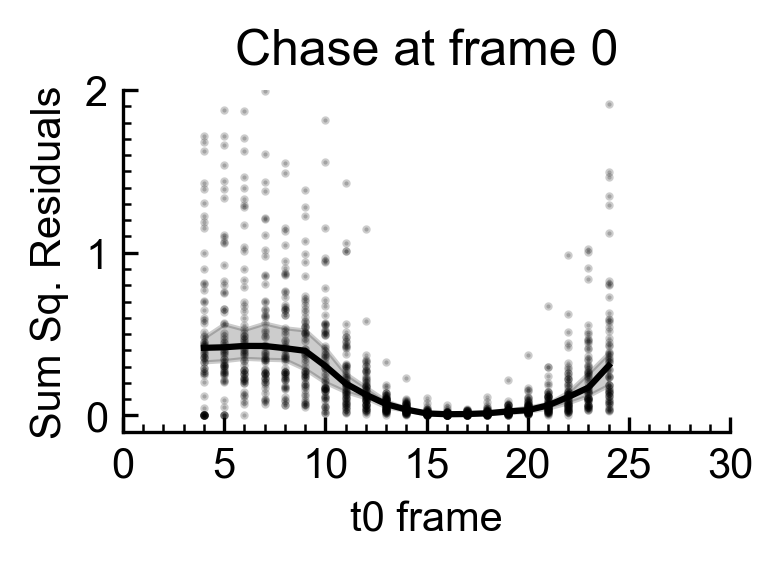

In [30]:
allscandf.index = range(len(allscandf))
scandf = allscandf
yvar = 'ss_residuals'
ylabel = 'Sum Sq. Residuals'
fig = plt.figure(figsize=(5, 2)) 
fig.set_dpi(300)
xlim = (0, 30)
ylim = (-0.1, 2)
size=1
color = 'black'
ax = fig.add_subplot(121)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(allscandf.start_frame, allscandf[yvar], s=size, color=color, alpha=0.2)
sns.lineplot(x='start_frame', y=yvar, data=allscandf,
             color='black', estimator=np.median, ax=ax)
ax.set_title(f'Chase at frame {first_crop_frame}')


for a in [ax]:
    a.set_ylabel(ylabel)
    a.set_xticks(np.arange(0, np.max(xlim)+1, 5))
    a.set_xlabel('t0 frame')    
    
plotting.format_ticks(ax)
plotting.remove_spines(ax)

plt.tight_layout()

In [44]:
allscandf.start_frame.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)

In [52]:
first_crop_frame = 148

kwargs = {
    'xmin': 0,
    'xmax': 20
}

scandfs = []
for tracedf in tracedfs:
    if tracedf.first_crop_frame.iloc[0] == first_crop_frame:
        print(f'Scanning fit start frames for cell {tracedf.cell_index.iloc[0]}')

        scandf = ft.scan_start_frames(tracedf,
                                      col_name='Mean_yfp_auto',
                                      xvar='frame_rel',
                                      **kwargs)
        scandfs.append(scandf)
allscandf = pd.concat(scandfs, sort=False)

Scanning fit start frames for cell 3
Fitting cell 3 frame 0.0
Start frame = 0
Length of y_raw = 31
Using background val: 153.6272040302267
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Attempting to make params_df
Fitting cell 3 frame 1.0
Start frame = 1
Length of y_raw = 31
Using background val: 152.74532710280374
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=3
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Attempting to make params_df
Fitting cell 3 frame 2.0
Start frame = 2
Length of y_raw = 31
Using background val: 152.14102564102564
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Could not fit cell with cell_index=3
Error: Optimal parameters not found

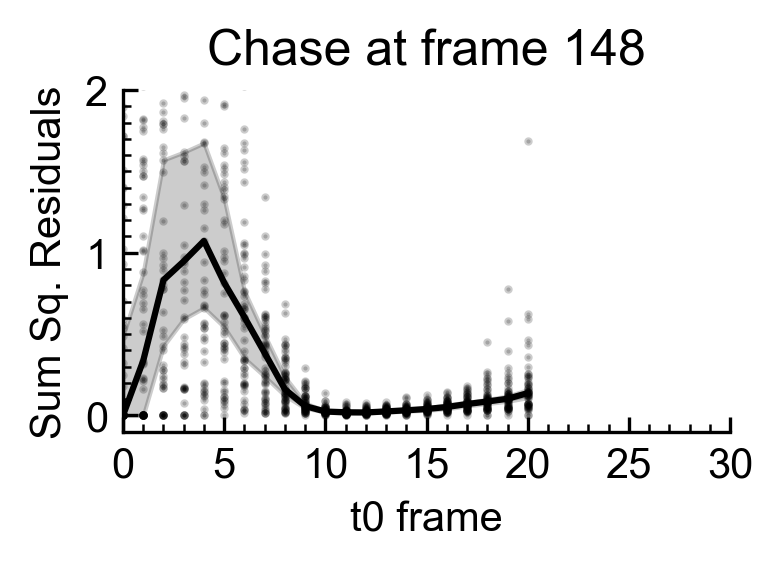

In [53]:
allscandf.index = range(len(allscandf))
scandf = allscandf
yvar = 'ss_residuals'
ylabel = 'Sum Sq. Residuals'
fig = plt.figure(figsize=(5, 2)) 
fig.set_dpi(300)
xlim = (0, 30)
ylim = (-0.1, 2)
size=1
color = 'black'
ax = fig.add_subplot(121)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(allscandf.start_frame, allscandf[yvar], s=size, color=color, alpha=0.2)
sns.lineplot(x='start_frame', y=yvar, data=allscandf,
             color='black', estimator=np.median, ax=ax)
ax.set_title(f'Chase at frame {first_crop_frame}')


for a in [ax]:
    a.set_ylabel(ylabel)
    a.set_xticks(np.arange(0, np.max(xlim)+1, 5))
    a.set_xlabel('t0 frame')    
    
plotting.format_ticks(ax)
plotting.remove_spines(ax)

plt.tight_layout()

In [54]:
crop_starts

array([  0., 147., 148., 149., 158.])

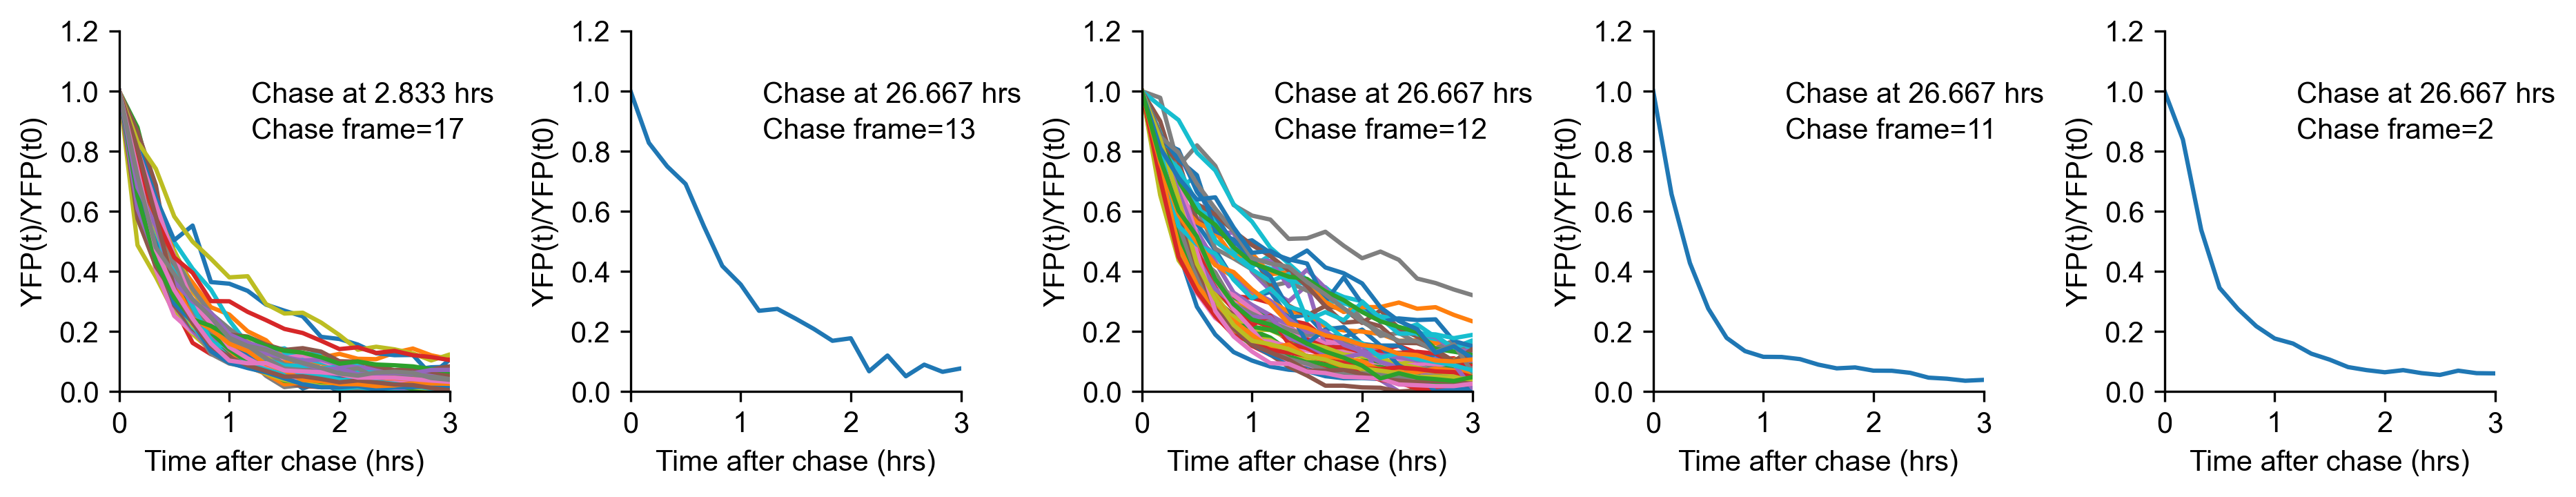

In [16]:
tracesdf = pd.concat(tracedfs, sort=False)

crop_starts = np.sort(list(tracesdf.first_crop_frame.unique()))
chase_frames = [17, 13, 12, 11, 2]

chase_frame_dict = dict(zip(list(crop_starts), chase_frames))

table = tracesdf
yvar = 'Mean_yfp_auto'
nrows = 1
ncols = len(crop_starts)
height = nrows*2.5
width = ncols*2.5
xlim = (0, 3)
ylim = (0, 1.2)
delta_t = 10
fig = plt.figure(figsize=(width, height))
fig.set_dpi(300)
axes = [fig.add_subplot(nrows, ncols, i+1) for i in range(len(crop_starts))]
axdict = dict(zip(crop_starts, axes))
# Plot each individual cell from each chase
for crop_start in crop_starts:
    ax = axdict[crop_start]
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    chase_frame = chase_frame_dict[crop_start]
    xy = (np.max(xlim)*0.4, np.max(ylim)*0.8)
    xy2 = (xy[0], np.max(ylim)*0.7)
    chase_hours = ((crop_start+chase_frame)*delta_t)/60
    chase_hours = np.round(chase_hours, 3)
    ax.annotate(f'Chase at {chase_hours} hrs', xy=xy)
    ax.annotate(f'Chase frame={chase_frame}', xy=xy2)
    startdf = table[table.first_crop_frame==crop_start]
    for cell_index in startdf.cell_index.unique():
        
        df = startdf[startdf.cell_index==cell_index]
        x = df.frame_rel[chase_frame:] - chase_frame
        x = (x*delta_t)/60
        y = df[yvar][chase_frame:] - df[yvar][:].min()
        y = y/y.iloc[0]
        ax.plot(x, y)
        ax.set_ylabel('YFP(t)/YFP(t0)')
        ax.set_xlabel('Time after chase (hrs)')
        plotting.remove_spines(ax)
plt.tight_layout()

In [9]:
# Relabel tracedfs after having determined chase starts above
channels = ['bf', 'yfp']
args = [exptname,
        compartmentname]
kwargs = {'age_state': 'old',
          'chase_frame_dict': chase_frame_dict}

mdf = sa.create_and_annotate_mdf(*args, **kwargs)
# Set chase frames in celldf table according to above
crop_starts = chase_frame_dict.keys()
# For some reason dist_from_sen is getting fucked up so redefine
# it straigt from master index df
for cell_index in mdf.cell_index.unique():
    abs_chase_frame = mdf[mdf.cell_index==cell_index].abs_chase_frame.iloc[0]
    dist_from_sen = mdf[mdf.cell_index==cell_index].dist_from_sen.iloc[0]
    table.loc[table.cell_index==cell_index, 'dist_from_sen'] = dist_from_sen
    table.loc[table.cell_index==cell_index, 'abs_chase_frame'] = abs_chase_frame

for crop_start in crop_starts:
    chase_frame = chase_frame_dict[crop_start]
    table.loc[table.first_crop_frame==crop_start, 'chase_frame'] = chase_frame
    

# Add a t0 normalized column to each trace dataframe
tracedfs = [table[table.cell_index==cidx] for cidx in table.cell_index.unique()]
for df in tracedfs:
    df.index = range(len(df))
tracedfs = [sa.t0_normalize_trace_df(tracedf,
                                     yvar='Mean_yfp_auto',
                                     norm_col_name='yfp_norm') for tracedf in tracedfs]



Found compartment directory:
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase
Found 114 potential crop_rois roi df .csv files
Saved master index df at:
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase_crop_rois.csv
Looking for crop roi set path for cell 0 at 
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase\20220610_byc_cell000_crop_rois.zip
Looking for crop roi set path for cell 1 at 
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase\20220610_byc_cell001_crop_rois.zip
Looking for crop roi set path for cell 2 at 
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase\20220610_byc_cell002_crop_rois.zip
Looking for crop roi set path for cell 3 at 
C:\Users\johnp\Dropbox\Projects\byc\da

c:\.byc\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\.byc\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Fit experiment to exponential

In [ ]:
palette = sns.color_palette("Spectral", n_colors=int(np.max(table.dist_from_sen))+1)

fig, ax = plotting.figure_ax(width_scale=1, height_scale=0.1)
ax.set_xlim(0, 27)
ax.set_xticks([0, 5, 10, 15, 20, 25])
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
plot = sns.palplot(palette)

Saved figure at:/nC:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\Yfp_vs_time_color_dist_from_sen.svg


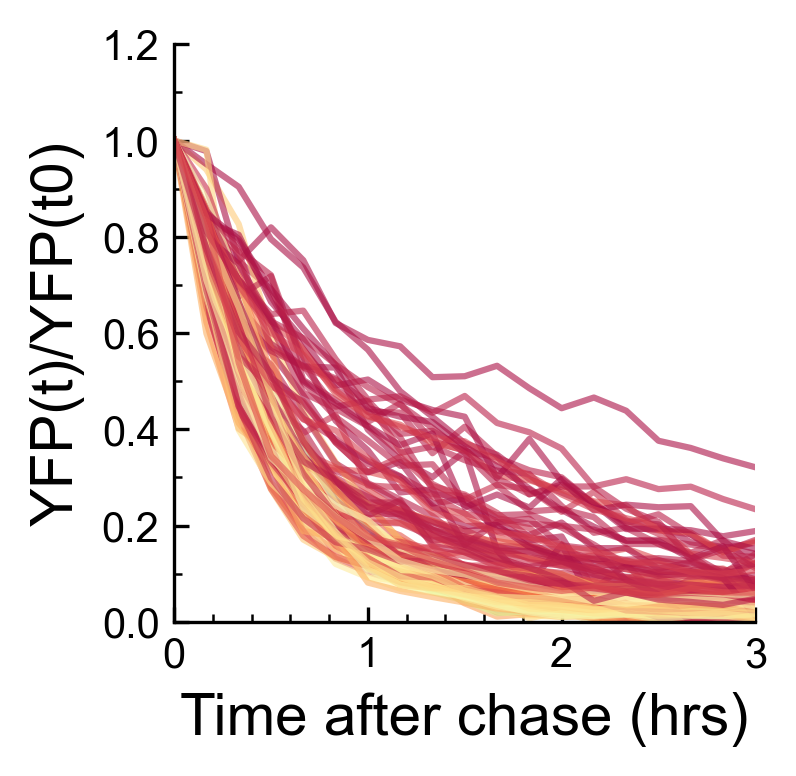

In [17]:
dfs = tracedfs
savefig=True
y_var = 'yfp_norm'
plotkwargs = {'alpha': 0.6,
              'linewidth': 1.5}

ylabel = 'YFP(t)/YFP(t0)'
xlabel = 'Time after chase (hrs)'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.unique()[0])
exptdir = os.path.abspath(os.path.join(compdir, '..'))
savepath = os.path.join(compdir, f'Yfp_vs_time_color_dist_from_sen.svg')

ylim = (0, 1.2)
xlim = (0, 3)
fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)

ax = fig.add_subplot(111)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    chase_frame = df.chase_frame.unique()[0]
    y = df.loc[chase_frame:, y_var]
    x = [(i*10)/60 for i in range(len(y))]
    dist_from_sen = df.dist_from_sen.iloc[0]
    if not np.isnan(dist_from_sen):
        color =palette[int(dist_from_sen)]
        ax.plot(x, y, color=color, label=f'Cell {i}', **plotkwargs)
    else:
        print(f'Dist from sen is nan for cell {df.cell_index.unique()[0]}')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for spine in [ax.spines[key] for key in ['top', 'right']]:
    spine.set_visible(False)
    
ax.set_ylabel(ylabel, fontsize=14)
ax.set_xlabel(xlabel, fontsize=14)
loc = (0.3*np.max(xlim), 0.9*np.max(ylim))
# ax.annotate(f'Chase frame = {chase_frame}', xy=loc)
plotting.format_ticks(ax, xminorspace=0.2, yminorspace=0.1)
if savefig:
    fig.savefig(savepath)
    print(f'Saved figure at:/n{savepath}')

In [18]:
col_name = 'Mean_yfp_auto'
fits_df = ft.get_all_fits_df(tracedfs, None, 30, col_name=col_name)
# Get rid of failed fit data
fits_df = fits_df[fits_df.b.isna() == False]

Fitting cell with index 0
Length of y_raw = 31
Using background val: 126.29392971246008
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 1
Length of y_raw = 31
Using background val: 140.95673076923077
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 2
Length of y_raw = 31
Using background val: 140.20639534883722
Length of y_raw = 31. Length of y_norm = 31
Fitting with x length 31 and y length 31
Calculating resids
Length of y_input 31. Length of y_pred 31
calculating R_squared
Calculating estimated standard error
Calculating shapiro_p
Fitting cell with index 3
Length of y_raw = 31
Using ba

In [1]:
filename = 'all_cell_fits.svg'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.iloc[0])
savepath = os.path.join(compdir, filename)

fits_df.sort_values(by='cell_index', inplace=True)
nrows = 19
ncols = 6
fig = plt.figure(figsize=(ncols*2.4, nrows*2.4))
fig.set_dpi(300)
i=1
xlim = (0, 3)
ylim = (0, 1.2)
for cell_index in fits_df.cell_index.unique():
    df = fits_df[fits_df.cell_index==cell_index]
    dist_from_sen = df.dist_from_sen.unique()[0]
    rate = np.round(df.b.unique()[0], 3)
    ax = fig.add_subplot(nrows, ncols, i)
    sns.scatterplot(x='x_input', y='y_input_norm', color='black',
                    data=df, ax=ax)
    sns.lineplot(x='x_input', y='y_pred_norm', color='black',
                 data=df, ax=ax)
    
    ax.set_title(f'Cell{cell_index}')
   
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    shapiro_p = df.shapiro_p.iloc[0]
    shapiro_p_round = np.round(shapiro_p, 3)
    xy = (0.5, np.max(ylim)*0.8)
    xyrate = (0.5, np.max(ylim)*0.7)
    xyabschase = (0.5, np.max(ylim)*0.6)
    if shapiro_p < 0.05:
        color= 'red'
    else:
        color='black'
    ax.annotate(f'Shapiro p={shapiro_p_round}', xy=xy, color=color)
    ax.annotate(f'Rate={rate}', xy=xyrate)
    abs_chase_frame = int(mdf.loc[mdf.cell_index==cell_index, 'abs_chase_frame'])
    ax.annotate(f'Abs chase frame={abs_chase_frame}', xy=xyabschase)
    i+=1
plt.tight_layout()
fig.savefig(savepath)
print(f'Figure saved at\n{savepath}')

NameError: name 'constants' is not defined

In [20]:
# Drop cells that are clearly bad data based on above plots
drops = [28]
fits_df = fits_df[~(fits_df.cell_index.isin(drops))].reset_index()

In [21]:
kwargs = {'mdf': mdf,
          'fits_df': fits_df,
          'drops': drops}
fits_df, fits_table = database.write_final_fits_dfs(**kwargs)

c:\.byc\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
c:\.byc\lib\site-packages\IPython\core\interactiveshell.py:3364: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):


Did not find 0 of 3474 in <df1>
Using ['age_at_chase', 'rls', 'dist_from_sen', 'first_bud_frame', 'cell_index'] to make pivot table of fits_df
Did not find 0 of 113 in <df1>
Saved exponential fits table at C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase\fits_table.csv
saved expanded exponential fits df at C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\20220610_byc_JPC196_SSA2-OE_in_JPC121_R-YFP-Su9_two-chase\allfitsdf.csv


N=113
Saved figure at: 
C:\Users\johnp\Dropbox\Projects\byc\data\20220610_byc\b_vs_dist_from_sen.svg


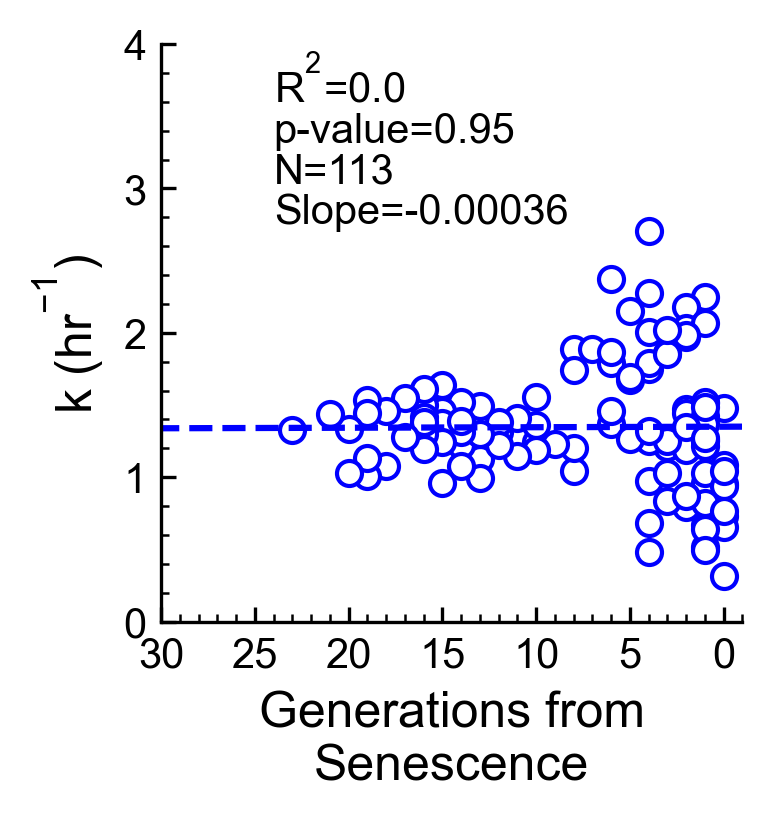

In [22]:
df = fits_table
mdf = mdf
yvar = 'b'
xvar = 'dist_from_sen'
scatterkwargs = {'color': 'white',
                 'edgecolor': 'blue'}
linekwargs = {'color': 'blue',
              'linestyle': '--'}
ylabel = 'k (hr$^{-1}$)'
xlabel = 'Generations from\nSenescence'
compdir = os.path.join(constants.byc_data_dir, mdf.compartment_reldir.unique()[0])
exptdir = os.path.abspath(os.path.join(compdir, '..'))
savepath = os.path.join(compdir, f'{yvar}_vs_{xvar}.svg')
from scipy.stats import linregress
ylim = (0, 4)
xlim = (30, -1)
xminorspace = 1
yminorspace = 0.1
xticks = np.linspace(xlim[0], 0, 7)
fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)

ax = fig.add_subplot(111)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
x = df.loc[:, xvar]
y = df.loc[:, yvar]
ax.scatter(x, y, **scatterkwargs)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for spine in [ax.spines[key] for key in ['top', 'right']]:
    spine.set_visible(False)
    
ax.set_ylabel(ylabel, fontsize=12)
ax.set_xlabel(xlabel, fontsize=12)

# Plot linear regression
slope, intercept, r, p, se = linregress(x, y)
x_smooth = np.linspace(np.min(xlim), np.max(xlim), 30)
y_pred = ft.line(x_smooth, slope, intercept)
r_sq = r*r
r_sq_term = 'R$^2$'
r_sq_label = f'{r_sq_term}={np.round(r_sq, 3)}'
ax.plot(x_smooth, y_pred, **linekwargs)
rloc = (0.8*np.max(xlim), 0.9*np.max(ylim))
ploc = (0.8*np.max(xlim), 0.83*np.max(ylim))
nloc = (0.8*np.max(xlim), 0.76*np.max(ylim))
sloc = (0.8*np.max(xlim), 0.69*np.max(ylim))
ax.annotate(f'{r_sq_label}', xy=rloc)
ax.annotate(f'p-value={np.round(p, 3)}', xy=ploc)
ax.annotate(f'N={len(y)}', xy=nloc)
ax.annotate(f'Slope={str(slope)[0:8]}', xy=sloc)
plotting.format_ticks(ax, xminorspace=xminorspace)
# ax.annotate(f'slope={np.round(slope, 3)}', xy=sloc)
print(f'N={len(df.loc[:, yvar])}')
fig.savefig(savepath)
print(f'Saved figure at: \n{savepath}')